In [41]:
import os
import time
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from sklearn.metrics import classification_report
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings("ignore")

In [3]:
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)
print("Using device:", device)


Using device: mps


In [4]:
image_tranforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(0.2,0.2,0.2),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
!ls

__pycache__                        Freshness.ipynb
damage_prediction.ipynb            FRUIT-16K
FreshHarvest_Dataset.zip           hyperparameter_tunning.ipynb
FreshHarvest_Problem_Statement.pdf predict.py


In [6]:
dataset_path = "./FRUIT-16K"
dataset = datasets.ImageFolder(root=dataset_path, transform=image_tranforms)
len(dataset)

16000

In [34]:
classes = dataset.classes
classes

['F_Banana',
 'F_Lemon',
 'F_Lulo',
 'F_Mango',
 'F_Orange',
 'F_Strawberry',
 'F_Tamarillo',
 'F_Tomato',
 'S_Banana',
 'S_Lemon',
 'S_Lulo',
 'S_Mango',
 'S_Orange',
 'S_Strawberry',
 'S_Tamarillo',
 'S_Tomato']

In [7]:
num_classes = len(dataset.classes)
dataset.class_to_idx

{'F_Banana': 0,
 'F_Lemon': 1,
 'F_Lulo': 2,
 'F_Mango': 3,
 'F_Orange': 4,
 'F_Strawberry': 5,
 'F_Tamarillo': 6,
 'F_Tomato': 7,
 'S_Banana': 8,
 'S_Lemon': 9,
 'S_Lulo': 10,
 'S_Mango': 11,
 'S_Orange': 12,
 'S_Strawberry': 13,
 'S_Tamarillo': 14,
 'S_Tomato': 15}

In [8]:
train_size = int(0.75 * (len(dataset)))
val_size = len(dataset) - train_size

train_size, val_size

(12000, 4000)

In [9]:
train_dataset, val_dataset = random_split(dataset=dataset, lengths=[train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

In [10]:
for imgs, lbls in train_loader:
    print(imgs.shape)
    print(lbls.shape)
    break

torch.Size([32, 3, 224, 224])
torch.Size([32])


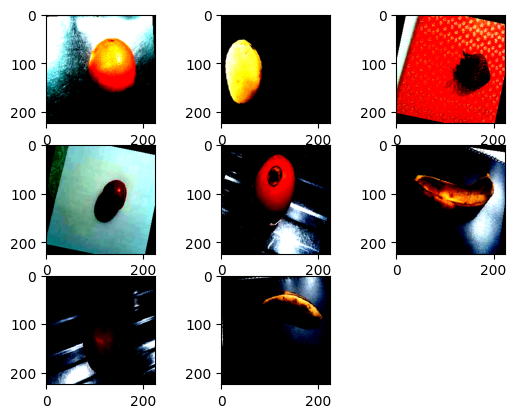

In [11]:
for i, (img, lbl) in enumerate(zip(imgs,lbls),1):
    if i > 8:
        break
    plt.subplot(3,3,i)
    plt.imshow(img.permute(1, 2, 0).clamp(0, 1))


In [12]:
class FruitCNN(nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1), # (16, 224, 224) 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (16, 112, 112),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (32, 56, 56)           
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (64, 28, 28),
            nn.Flatten(),
            nn.Linear(64*28*28, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )
        

    def forward(self, x):
        x = self.network(x)
        return x

In [13]:
model = FruitCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [14]:
def train_model(model, criterion, optimizer, epochs):
    start = time.time()
    train_acc_history = []
    val_acc_history = []

    for epoch in range(epochs):
        model.train()
        correct_train = 0
        total_train = 0
        running_loss = 0.0
        for batch_num, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()
            
            if (batch_num+1) % 100 == 0:
                print(f"Batch number : {batch_num+1}, Epoch number : {epoch+1}, batch loss : {loss.item():0.2f}")

            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        
        print(f"Epoch [{epoch+1}/{epochs}], Avg Loss: {epoch_loss:.4f}")

        predicted = torch.argmax(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
        train_acc = correct_train / total_train
        train_acc_history.append(train_acc)

        
        model.eval()
        correct_val = 0
        total_val = 0
        all_labels = []
        all_predictions = []
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                predicted = torch.argmax(outputs,1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())
                
            print(f"*** Validation Accuracy: {100 * correct_val / total_val:.2f}% ***")

        val_acc = correct_val / total_val
        val_acc_history.append(val_acc)
        end = time.time()
    print(f"Execution time: {end - start} seconds")     
    
    return all_labels, all_predictions, train_acc_history, val_acc_history
        

In [15]:
all_labels, all_predictions, train_acc_history, val_acc_history = train_model(model, criterion, optimizer,  epochs=10)

Batch number : 100, Epoch number : 1, batch loss : 1.50
Batch number : 200, Epoch number : 1, batch loss : 0.88
Batch number : 300, Epoch number : 1, batch loss : 0.72
Epoch [1/10], Avg Loss: 1.2743
*** Validation Accuracy: 71.03% ***
Batch number : 100, Epoch number : 2, batch loss : 0.35
Batch number : 200, Epoch number : 2, batch loss : 0.29
Batch number : 300, Epoch number : 2, batch loss : 0.40
Epoch [2/10], Avg Loss: 0.5239
*** Validation Accuracy: 85.53% ***
Batch number : 100, Epoch number : 3, batch loss : 0.27
Batch number : 200, Epoch number : 3, batch loss : 0.43
Batch number : 300, Epoch number : 3, batch loss : 0.24
Epoch [3/10], Avg Loss: 0.3463
*** Validation Accuracy: 88.75% ***
Batch number : 100, Epoch number : 4, batch loss : 0.44
Batch number : 200, Epoch number : 4, batch loss : 0.36
Batch number : 300, Epoch number : 4, batch loss : 0.24
Epoch [4/10], Avg Loss: 0.2439
*** Validation Accuracy: 86.47% ***
Batch number : 100, Epoch number : 5, batch loss : 0.31
Batc

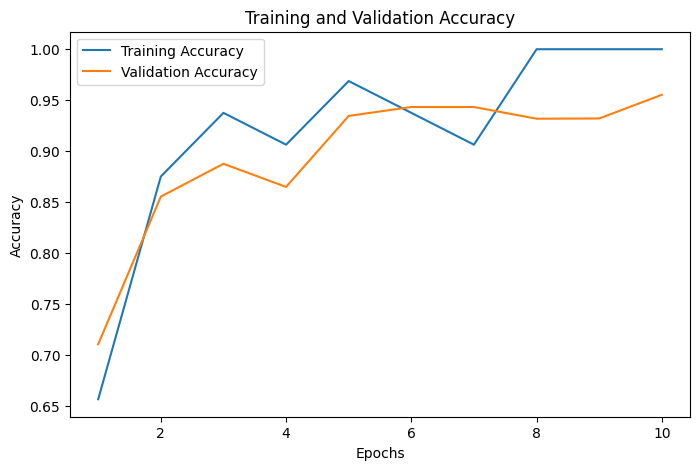

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(range(1, 11), train_acc_history, label='Training Accuracy')
plt.plot(range(1, 11), val_acc_history, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


In [17]:
class FruitCNNRegular(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1), # (16, 224, 224) 
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (16, 112, 112),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (32, 56, 56)           
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (64, 28, 28),
            nn.Flatten(),
            nn.Linear(64*28*28, 512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        x = self.network(x)
        return x

In [18]:
model = FruitCNNRegular(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
all_labels, all_predictions, train_acc_history, val_acc_history = train_model(model, criterion, optimizer,  epochs=10)

In [20]:
import optuna

In [21]:
def objective(trial):

    # Load the model
    model = FruitCNNRegular(num_classes=num_classes, dropout_rate=0.5).to(device)
    epochs = 3
    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.7)
    
    start = time.time()
    train_acc_history = []
    val_acc_history = []

    for epoch in range(epochs):
        model.train()
        correct_train = 0
        total_train = 0
        running_loss = 0.0
        for batch_num, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()
            
            if (batch_num+1) % 100 == 0:
                print(f"Batch number : {batch_num+1}, Epoch number : {epoch+1}, batch loss : {loss.item():0.2f}")

            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        
        print(f"Epoch [{epoch+1}/{epochs}], Avg Loss: {epoch_loss:.4f}")

        predicted = torch.argmax(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
        train_acc = correct_train / total_train
        train_acc_history.append(train_acc)

        
        model.eval()
        correct_val = 0
        total_val = 0
        all_labels = []
        all_predictions = []
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                predicted = torch.argmax(outputs,1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())
                
            print(f"*** Validation Accuracy: {100 * correct_val / total_val:.2f}% ***")

            val_acc = correct_val / total_val
            val_acc_history.append(val_acc)
        
        # Report intermediate result to Optuna
        trial.report(val_acc, epoch)
        
        # Handle pruning (if applicable)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    
    end = time.time()
    print(f"Execution time: {end - start} seconds")     
    
    return val_acc
        

In [22]:
# Create the study and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5)



[I 2025-09-18 19:18:56,489] A new study created in memory with name: no-name-fa44f6c5-0d8b-4eff-a652-9bf0a120674f


Batch number : 100, Epoch number : 1, batch loss : 2.68
Batch number : 200, Epoch number : 1, batch loss : 2.60
Batch number : 300, Epoch number : 1, batch loss : 2.55
Epoch [1/3], Avg Loss: 3.0671
*** Validation Accuracy: 28.07% ***
Batch number : 100, Epoch number : 2, batch loss : 2.03
Batch number : 200, Epoch number : 2, batch loss : 2.35
Batch number : 300, Epoch number : 2, batch loss : 2.14
Epoch [2/3], Avg Loss: 2.2375
*** Validation Accuracy: 36.02% ***
Batch number : 100, Epoch number : 3, batch loss : 2.09
Batch number : 200, Epoch number : 3, batch loss : 2.20
Batch number : 300, Epoch number : 3, batch loss : 1.70
Epoch [3/3], Avg Loss: 2.0171


[I 2025-09-18 19:21:32,544] Trial 0 finished with value: 0.4455 and parameters: {'lr': 0.0005009799183246554, 'dropout_rate': 0.6947617200002569}. Best is trial 0 with value: 0.4455.


*** Validation Accuracy: 44.55% ***
Execution time: 155.9478919506073 seconds
Batch number : 100, Epoch number : 1, batch loss : 2.52
Batch number : 200, Epoch number : 1, batch loss : 2.56
Batch number : 300, Epoch number : 1, batch loss : 2.21
Epoch [1/3], Avg Loss: 3.0621
*** Validation Accuracy: 29.98% ***
Batch number : 100, Epoch number : 2, batch loss : 2.25
Batch number : 200, Epoch number : 2, batch loss : 2.02
Batch number : 300, Epoch number : 2, batch loss : 1.98
Epoch [2/3], Avg Loss: 2.1232
*** Validation Accuracy: 39.02% ***
Batch number : 100, Epoch number : 3, batch loss : 1.67
Batch number : 200, Epoch number : 3, batch loss : 1.80
Batch number : 300, Epoch number : 3, batch loss : 1.85
Epoch [3/3], Avg Loss: 1.9331


[I 2025-09-18 19:24:11,059] Trial 1 finished with value: 0.4515 and parameters: {'lr': 1.2966116257921492e-05, 'dropout_rate': 0.24265857971442006}. Best is trial 1 with value: 0.4515.


*** Validation Accuracy: 45.15% ***
Execution time: 158.47151899337769 seconds
Batch number : 100, Epoch number : 1, batch loss : 2.40
Batch number : 200, Epoch number : 1, batch loss : 2.50
Batch number : 300, Epoch number : 1, batch loss : 1.72
Epoch [1/3], Avg Loss: 2.7845
*** Validation Accuracy: 40.83% ***
Batch number : 100, Epoch number : 2, batch loss : 2.84
Batch number : 200, Epoch number : 2, batch loss : 1.59
Batch number : 300, Epoch number : 2, batch loss : 1.72
Epoch [2/3], Avg Loss: 1.8320
*** Validation Accuracy: 48.35% ***
Batch number : 100, Epoch number : 3, batch loss : 1.58
Batch number : 200, Epoch number : 3, batch loss : 1.92
Batch number : 300, Epoch number : 3, batch loss : 1.46
Epoch [3/3], Avg Loss: 1.6576


[I 2025-09-18 19:26:47,332] Trial 2 finished with value: 0.5965 and parameters: {'lr': 3.115942639307652e-05, 'dropout_rate': 0.33194699705735686}. Best is trial 2 with value: 0.5965.


*** Validation Accuracy: 59.65% ***
Execution time: 156.21783089637756 seconds
Batch number : 100, Epoch number : 1, batch loss : 2.66
Batch number : 200, Epoch number : 1, batch loss : 2.53
Batch number : 300, Epoch number : 1, batch loss : 2.64
Epoch [1/3], Avg Loss: 3.1280
*** Validation Accuracy: 32.23% ***
Batch number : 100, Epoch number : 2, batch loss : 2.32
Batch number : 200, Epoch number : 2, batch loss : 2.21
Batch number : 300, Epoch number : 2, batch loss : 2.33
Epoch [2/3], Avg Loss: 2.1504
*** Validation Accuracy: 42.12% ***
Batch number : 100, Epoch number : 3, batch loss : 2.08
Batch number : 200, Epoch number : 3, batch loss : 1.64
Batch number : 300, Epoch number : 3, batch loss : 2.19
Epoch [3/3], Avg Loss: 1.9523


[I 2025-09-18 19:29:29,942] Trial 3 finished with value: 0.45525 and parameters: {'lr': 0.0009581915739556092, 'dropout_rate': 0.43986584172664817}. Best is trial 2 with value: 0.5965.


*** Validation Accuracy: 45.52% ***
Execution time: 162.55836391448975 seconds
Batch number : 100, Epoch number : 1, batch loss : 2.61
Batch number : 200, Epoch number : 1, batch loss : 2.62
Batch number : 300, Epoch number : 1, batch loss : 2.35
Epoch [1/3], Avg Loss: 3.1456
*** Validation Accuracy: 34.90% ***
Batch number : 100, Epoch number : 2, batch loss : 1.86
Batch number : 200, Epoch number : 2, batch loss : 1.92
Batch number : 300, Epoch number : 2, batch loss : 2.07
Epoch [2/3], Avg Loss: 1.9918
*** Validation Accuracy: 42.02% ***
Batch number : 100, Epoch number : 3, batch loss : 1.77
Batch number : 200, Epoch number : 3, batch loss : 1.73
Batch number : 300, Epoch number : 3, batch loss : 1.69
Epoch [3/3], Avg Loss: 1.8156


[I 2025-09-18 19:32:22,393] Trial 4 finished with value: 0.51525 and parameters: {'lr': 0.0005914552975736166, 'dropout_rate': 0.38196269186951815}. Best is trial 2 with value: 0.5965.


*** Validation Accuracy: 51.52% ***
Execution time: 172.39847707748413 seconds


In [27]:
class FruitCNNResNet(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5):
        super().__init__()
        self.model = models.resnet50(weights='DEFAULT')
        # Freeze all layers except the final fully connected layer
        for param in self.model.parameters():
            param.requires_grad = False
            
        # Unfreeze layer4 and fc layers
        for param in self.model.layer4.parameters():
            param.requires_grad = True            
            
        # Replace the final fully connected layer
        self.model.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(self.model.fc.in_features, num_classes)
        )

    def forward(self, x):
        x = self.model(x)
        return x

In [29]:
model = FruitCNNResNet(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

all_labels, all_predictions, train_acc_history, val_acc_history = train_model(model, criterion, optimizer, epochs=2)

Batch number : 100, Epoch number : 1, batch loss : 0.04
Batch number : 200, Epoch number : 1, batch loss : 0.05
Batch number : 300, Epoch number : 1, batch loss : 0.13
Epoch [1/2], Avg Loss: 0.1751
*** Validation Accuracy: 99.62% ***
Batch number : 100, Epoch number : 2, batch loss : 0.01
Batch number : 200, Epoch number : 2, batch loss : 0.02
Batch number : 300, Epoch number : 2, batch loss : 0.08
Epoch [2/2], Avg Loss: 0.0260
*** Validation Accuracy: 99.90% ***
Execution time: 378.1632750034332 seconds


In [38]:

report = classification_report(all_labels, all_predictions)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       259
           1       1.00      1.00      1.00       264
           2       1.00      1.00      1.00       240
           3       1.00      1.00      1.00       223
           4       1.00      1.00      1.00       237
           5       1.00      1.00      1.00       252
           6       1.00      1.00      1.00       262
           7       1.00      1.00      1.00       253
           8       1.00      1.00      1.00       257
           9       1.00      0.99      1.00       269
          10       1.00      1.00      1.00       243
          11       1.00      1.00      1.00       249
          12       0.99      1.00      1.00       251
          13       1.00      1.00      1.00       258
          14       1.00      1.00      1.00       228
          15       1.00      1.00      1.00       255

    accuracy                           1.00      4000
   macro avg       1.00   

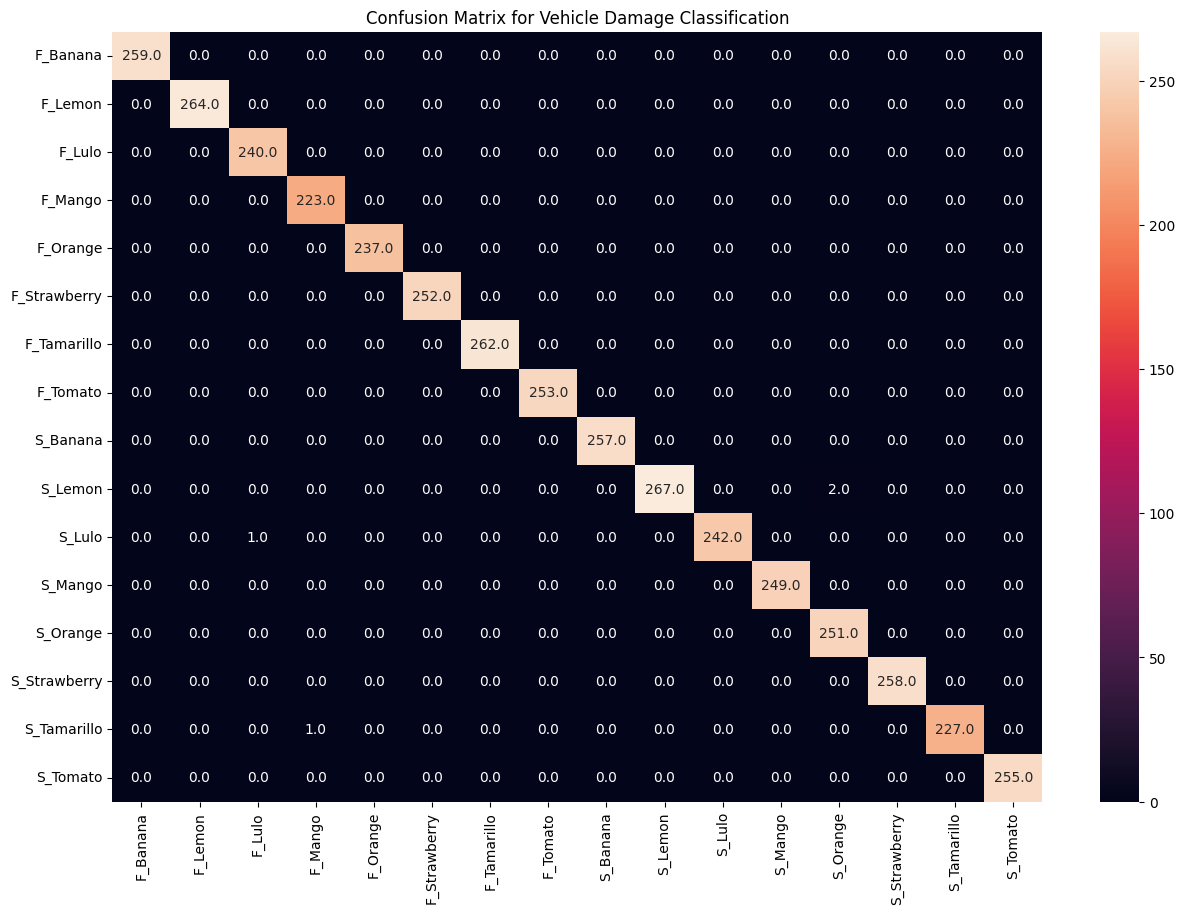

In [59]:
import seaborn as sns
plt.figure(figsize=(15,10))
conf_matrix = confusion_matrix(all_labels, all_predictions, labels=np.arange(num_classes))
sns.heatmap(conf_matrix, xticklabels=classes, yticklabels=classes, fmt=".1f", annot=True)
# disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=classes)
# disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix for Vehicle Damage Classification")
plt.show()

In [60]:
torch.save(model.state_dict(), 'saved_model.pth')